[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-random-projection/random_projection.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-random-projection/random_projection.ipynb)

# Random Projection

First we read our data - we will use the **Sift1M** dataset.

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# now define a function to read the fvecs file format of Sift1M dataset
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

# 1M samples
wb = read_fvecs('../../../data/sift/sift_base.fvecs')
# queries
xq = read_fvecs('../../../data/sift/sift_query.fvecs')

We can build our random projection hashing function like so:

In [2]:
def all_binary(n):
    total = 1 << n
    print(f"{total} possible combinations")
    combinations = []
    for i in range(total):
        # get binary representation of integer
        b = bin(i)[2:]
        # pad zeros to start of binary representtion
        b = '0' * (n - len(b)) + b
        b = [int(i) for i in b]
        combinations.append(b)
    return combinations

class RandomProjection:
    # initialize what will be the buckets
    buckets = {}
    # initialize counter
    counter = 0

    def __init__(self, nbits, d):
        self.nbits = nbits
        self.d = d
        # create our hyperplane normal vecs for splitting data
        self.plane_norms = np.random.rand(d, nbits) - .5
        print(f"Initialized {self.plane_norms.shape[1]} hyperplane normal vectors.")
        # add every possible combination to hashes attribute as numpy array
        self.hashes = all_binary(nbits)
        # and add each as a key to the buckets dictionary
        for hash_code in self.hashes:
            # convert to string
            hash_code = ''.join([str(i) for i in hash_code])
            self.buckets[hash_code] = []
        # convert self.hashes to numpy array
        self.hashes = np.stack(self.hashes)

    def get_binary(self, vec):
        # calculate nbits dot product values
        direction = np.dot(vec, projection.plane_norms)
        # find positive direction (>0) and negative direction (<=0)
        direction = direction > 0
        # convert boolean array to integer strings
        binary_hash = direction.astype(int)
        return binary_hash
        
    def hash_vec(self, vec, show=False):
        # generate hash
        binary_hash = self.get_binary(vec)
        # convert to string format for dictionary
        binary_hash = ''.join(binary_hash.astype(str))
        # add ID to buckets dictionary
        self.buckets[binary_hash].append(self.counter)
        if show:
            print(f"{self.counter}: {''.join(binary_hash)}")
        # increment counter
        self.counter += 1
    
    def hamming(self, hashed_vec):
        # get hamming distance between query vec and all buckets in self.hashes
        hamming_dist = np.count_nonzero(hashed_vec != projection.hashes, axis=1).reshape(-1, 1)
        # add hash values to each row
        hamming_dist = np.concatenate((projection.hashes, hamming_dist), axis=1)
        # sort based on distance
        hamming_dist = hamming_dist[hamming_dist[:, -1].argsort()]
        return hamming_dist
    
    def top_k(self, vec, k=5):
        # generate hash
        binary_hash = self.get_binary(vec)
        # calculate hamming distance between all vectors
        hamming_dist = self.hamming(binary_hash)
        # loop through each bucket until we have k or more vector IDs
        vec_ids = []
        for row in hamming_dist:
            str_hash = ''.join(row[:-1].astype(str))
            bucket_ids = self.buckets[str_hash]
            vec_ids.extend(bucket_ids)
            if len(vec_ids) >= k:
                vec_ids = vec_ids[:k]
                break
        # return top k IDs
        return vec_ids

In [24]:
projection.plane_norms.shape

(128, 12)

In [3]:
projection = RandomProjection(4, wb.shape[1])

Initialized 4 hyperplane normal vectors.
16 possible combinations


In [4]:
projection.hashes

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

We now have `16` groups that our vectors can be bucketed into. We run the bucketing process using the `hash_vec` method of `RandomProjection`.

In [5]:
projection.hash_vec(wb[0], show=True)

0: 0100


If we check the `projection.buckets` - where we have all all of our hash to ID mappings - we will find the same hash `0001` mapped to the value `0` - this is our *vector ID*, which we will simply use to keep track of our vectors.

In [6]:
projection.buckets

{'0000': [],
 '0001': [],
 '0010': [],
 '0011': [],
 '0100': [0],
 '0101': [],
 '0110': [],
 '0111': [],
 '1000': [],
 '1001': [],
 '1010': [],
 '1011': [],
 '1100': [],
 '1101': [],
 '1110': [],
 '1111': []}

Let's continue bucketing all of the vectors in `wb` - this will take a few seconds.

In [7]:
for i in range(1, len(wb)-1):
    projection.hash_vec(wb[i])

Now let us have another look at the beginning of our `projection.buckets` - we will find that there are now many more vector IDs indexed.

In [8]:
projection.buckets

{'0000': [1,
  3,
  6,
  7,
  8,
  ...
  504284,
  505108,
  505360,
  505670,
  ...]}

By adding each vector ID, this allows us to keep track of all rows (which we can map back to our original data) that have been grouped into each hash.

Although inside our LSH index we **only** keep the lower resolution binary hashes, which we will later compare using Hamming distance. This can be problematic when we have *many* vectors being mapped to the same hash buckets - as we lose the ability to distinguish between each of those.

In [9]:
for code in projection.hashes:
    code_str = ''.join(code.astype(str))
    print(f"{code_str}: {len(projection.buckets[code_str])}")

0000: 171125
0001: 100654
0010: 20754
0011: 16737
0100: 310361
0101: 101092
0110: 9079
0111: 4126
1000: 35584
1001: 17225
1010: 4493
1011: 2306
1100: 149024
1101: 49430
1110: 5952
1111: 2057


And we have many vectors mapped to each bucket. This is a problem but let's keep going and see what we return.

Let's find the top `k` results for a single query vector from `xq`.

In [10]:
top_10 = projection.top_k(xq[0], k=10)
top_10

[5, 13, 22, 26, 35, 37, 38, 39, 149, 152]

As we already noted, our LSH index does **not** contain the original vectors, just the binary hashes. But we do have the ID values so we can map that back to our `wb` array to return the original vectors and calculate the original cosine similarity to see how accurate our LSH implementation is.

In [11]:
cos = cosine_similarity(wb[top_10], [xq[0]])
np.mean(cos)

0.50619876

Now let's compare that to the cosine similarity from comparing all vectors in `wb`.

In [12]:
cos = cosine_similarity(wb, [xq[0]])
np.mean(cos)

0.4223302

Okay, we get a slightly higher similarity from our top k vectors returned with our LSH implementation - however, this this could simply be beginners luck. So let's try a couple more queries, we'll write a function `sim_check` for running through the process.

In [13]:
def sim_check(query_vecs):
    results = {'xq': [], 'wb': []}
    for xq in query_vecs:
        top_10 = projection.top_k(xq, k=10)
        cos = cosine_similarity(wb[top_10], [xq])
        cos = np.mean(cos)
        results['xq'].append(cos)
        cos = cosine_similarity(wb, [xq])
        cos = np.mean(cos)    
        results['wb'].append(cos)
    print(f"xq: {np.mean(results['xq'])}")
    print(f"wb: {np.mean(results['wb'])}")
    return results

In [14]:
results = sim_check(xq[:50])

xq: 0.5412288904190063
wb: 0.43162330985069275


Okay awesome, so even after compressing our vectors of dimensionality `128` into **binary** vectors of dimensionality `4`, we have still retained enough information to produce slightly better than average results.

*But*, they're not great. Within this dataset there are many high-similarity pairs with cosine similarity of ~0.8 - so returning an average of *0.53* is not exactly perfect.

So what do we do? We have one parameter that we can modify, the `nbits` value. We increase the `nbits` value to increase the *resolution* of our hashing function, which means we will have smaller, more accurate buckets, and that leads search-quality to increase. *But* at the same time also means we have a larger index, more values to compare, and those values contain more dimensions. So tuning this parameter is a balancing act between increasing *search-quality* while maintaining a reasonable *search-speed*.

Our performance is not great with an `nbits` value of `4`, let's increase that to an `nbits` value of `8`.

In [15]:
projection.hashes

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

In [16]:
''.join(projection.hashes[-5:][0].astype(str))

'1011'

In [17]:
d = wb.shape[0]
# initialize projection object
projection = RandomProjection(8, wb.shape[1])
# add all our vectors
for i in range(len(wb)-1):
    projection.hash_vec(wb[i])

# we would expect generally smaller buckets
for code in projection.hashes[:5]:
    str_code = ''.join(code.astype(str))
    print(f"{str_code}: {len(projection.buckets[str_code])}")

Initialized 8 hyperplane normal vectors.
256 possible combinations
00000000: 247
00000001: 4667
00000010: 305
00000011: 2489
00000100: 2630


Now we see that we have much smaller groups. Which means that we should find slightly better search-quality when returning `k` of the nearest neighbors. Let's rerun `sim_check` and see what we get. 

In [18]:
results = sim_check(xq[:50])

xq: 0.6719443798065186
wb: 0.43162330985069275


Much better results, of-course, we could continue increasing `nbits` to get better and better results - however we would ideally want to do this with an optimized implementation of LSH - not what we are using here. In that case, we have many options - the `faiss` library includes an `IndexLSH` function which allows us to build an efficient LSH index which we can fine-tune using the `nbits` parameter as we have done here.

For now, let's leave our implementation with a small visualization of our `check_sim` performance against multiple `nbits` values.

In [19]:
testing = pd.DataFrame({
    'nbits': [],
    'xq_sim': []
})

num_vecs = 50

for epoch in range(3):
    print('.')
    for nbits in [2, 4, 8, 12]:
        # initialize projection object
        projection = RandomProjection(nbits, wb.shape[1])
        # add all our vectors
        for i in range(len(wb)-1):
            projection.hash_vec(wb[i])
        # get results from sim_check
        results = sim_check(xq[:num_vecs])
        testing = testing.append(pd.DataFrame({
            'nbits': [nbits]*num_vecs,
            'xq_sim': results['xq']
        }), ignore_index=True)

.
Initialized 2 hyperplane normal vectors.
4 possible combinations
xq: 0.5848360061645508
wb: 0.43162330985069275
Initialized 4 hyperplane normal vectors.
16 possible combinations
xq: 0.5784505009651184
wb: 0.43162330985069275
Initialized 8 hyperplane normal vectors.
256 possible combinations
xq: 0.6728818416595459
wb: 0.43162330985069275
Initialized 12 hyperplane normal vectors.
4096 possible combinations
xq: 0.7043259143829346
wb: 0.43162330985069275
.
Initialized 2 hyperplane normal vectors.
4 possible combinations
xq: 0.530998706817627
wb: 0.43162330985069275
Initialized 4 hyperplane normal vectors.
16 possible combinations
xq: 0.6618399620056152
wb: 0.43162330985069275
Initialized 8 hyperplane normal vectors.
256 possible combinations
xq: 0.6009592413902283
wb: 0.43162330985069275
Initialized 12 hyperplane normal vectors.
4096 possible combinations
xq: 0.676262617111206
wb: 0.43162330985069275
.
Initialized 2 hyperplane normal vectors.
4 possible combinations
xq: 0.525986790657043

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

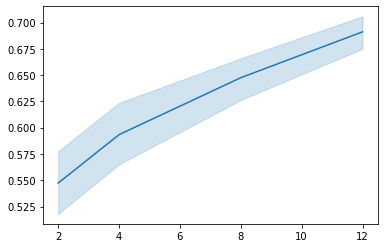

In [22]:
sns.lineplot(x=testing['nbits'].tolist(), y=testing['xq_sim'].tolist())